In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

os.chdir("/home/jp4474/latent-abc-smc")


from systems import SpatialSIR3D

2025-07-23 14:28:21.311995: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-23 14:28:21.320287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753280901.328901 2498648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753280901.331538 2498648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753280901.339406 2498648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
generations = np.load("/home/jp4474/latent-abc-smc/spatialSIR3D_d128_ed64_6_8_4_8_vae_mask_0.15_beta_0.1/spatial_sir_inference_pairwise_cosine.npz", allow_pickle=True)['generations']
last_generation = generations[-1]
particles = last_generation['particles']
weights = last_generation['weights']

In [4]:
np.average(particles, axis=0, weights=weights)

array([1.01990342, 1.05916116])

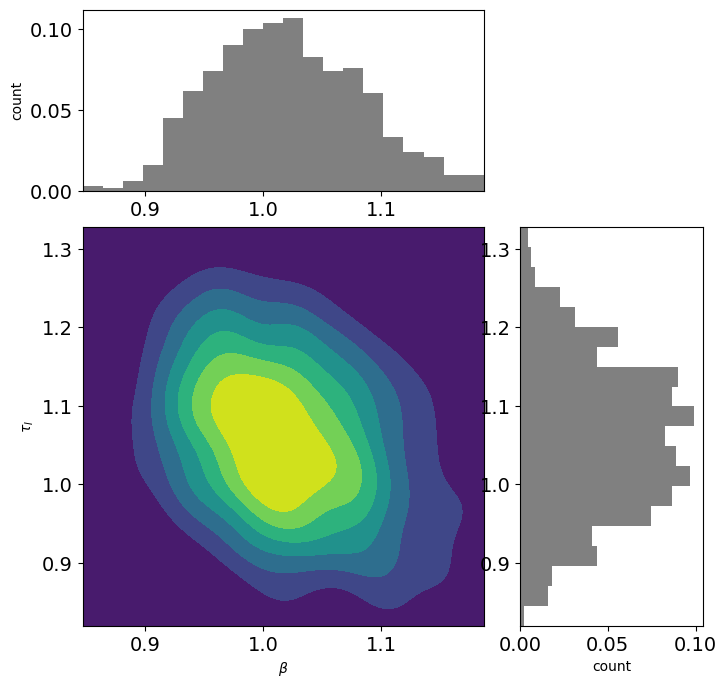

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
import numpy as np

x = particles[:, 0]
y = particles[:, 1]

# Estimate 2D density
# xy = np.vstack([x, y])
kde = gaussian_kde(particles.T, weights=weights, bw_method='scott')
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi = kde(np.vstack([xi.ravel(), yi.ravel()]))

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2], sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2], sharey=ax_main)
    
cf = ax_main.contourf(xi, yi, zi.reshape(xi.shape))
ax_main.set_xlabel(r"$\beta$")
ax_main.set_ylabel(r"$\tau_I$")

ax_xDist.hist(x,bins=20, align='mid', color="gray", weights=weights)
ax_xDist.set(ylabel='count')

ax_yDist.hist(y,bins=20, orientation='horizontal',align='mid', color="gray", weights=weights)
ax_yDist.set(xlabel='count')

# Change the font size of the axes labels
ax_main.tick_params(labelsize=14)
ax_xDist.tick_params(labelsize=14)
ax_yDist.tick_params(labelsize=14)


#plt.savefig(f"SIRS_kde.pdf", dpi=300)
plt.show()


In [6]:
data = pd.read_csv('/home/jp4474/latent-abc-smc/notebooks_sir/beta_metric_experiments.csv')

In [7]:
data.head()

,beta,mean_beta,mean_tau,variance_beta,variance_tau,num_of_sim,metric,sim_id
0,0.000,1.030074,0.908250,0.005566,0.018509,197762,bertscore,1
1,0.100,1.017360,1.060928,0.004839,0.011810,116475,bertscore,1
2,0.010,1.019057,1.035339,0.007102,0.014328,83078,bertscore,1
3,0.001,1.040852,0.979147,0.006232,0.019838,208711,bertscore,1
4,0.000,1.036008,0.911652,0.006344,0.018709,232340,pairwise,1


In [8]:
fig_data = data.groupby(['beta', 'metric']).aggregate({
    'mean_beta': 'mean',
    'mean_tau': 'mean',
    'variance_beta': 'mean',
    'variance_tau': 'mean',
    'num_of_sim': 'mean',
}).reset_index()

In [9]:
fig_data

,beta,metric,mean_beta,mean_tau,variance_beta,variance_tau,num_of_sim
0,0.000,bertscore,1.024148,0.921761,0.007652,0.024645,135293.4
1,0.000,pairwise,1.029606,0.917241,0.006561,0.022196,155953.6
2,0.001,bertscore,1.035202,0.988687,0.006264,0.021288,206400.0
3,0.001,pairwise,1.039578,0.981653,0.005308,0.018723,237044.0
4,0.010,bertscore,1.008507,1.052822,0.012347,0.028029,71150.6
5,0.010,pairwise,1.005708,1.060750,0.016034,0.036044,57288.6
6,0.100,bertscore,1.015839,1.060229,0.004740,0.011161,106546.2
7,0.100,pairwise,1.017822,1.059821,0.004279,0.010130,151888.6


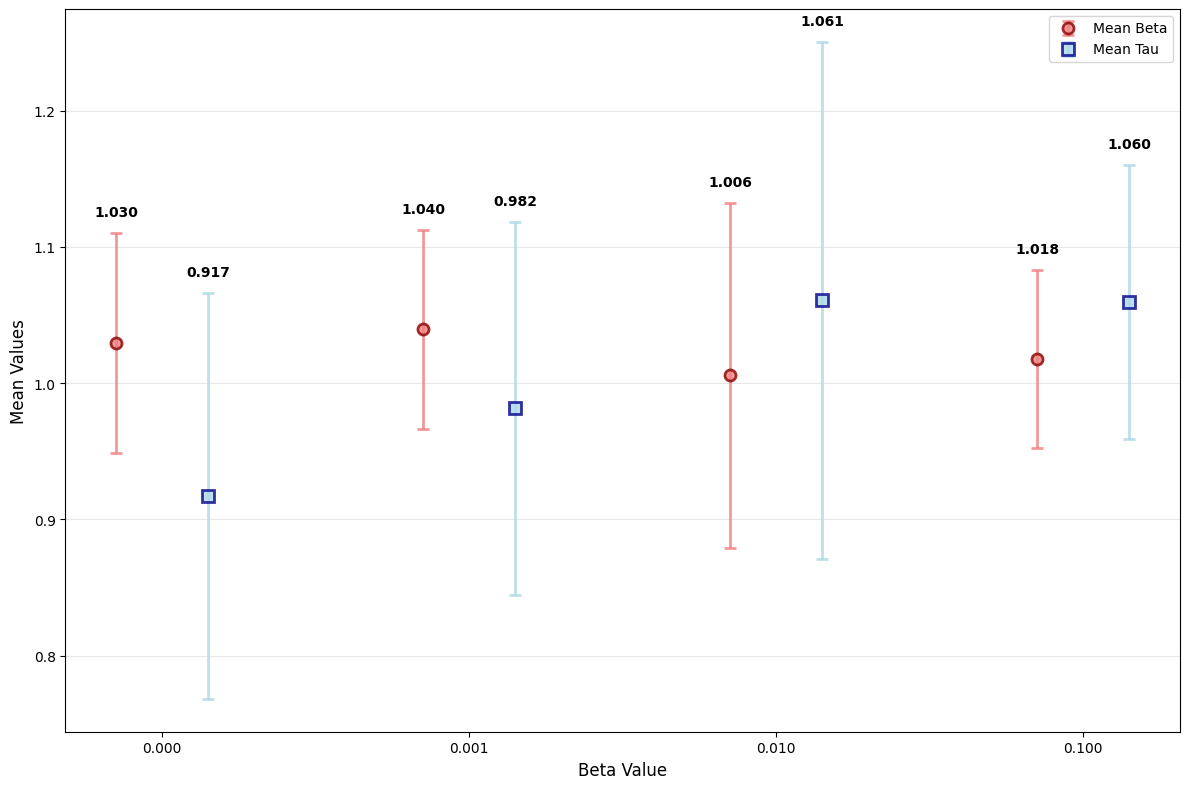

In [10]:
# Create scatter plot for pairwise metric showing beta and tau values with dots
fig, ax = plt.subplots(figsize=(12, 8))

# Filter data for pairwise metric only
pairwise_data = fig_data[fig_data['metric'] == 'pairwise'].copy()

# Get beta values and corresponding data
beta_values = pairwise_data['beta'].values
mean_beta_values = pairwise_data['mean_beta'].values
mean_tau_values = pairwise_data['mean_tau'].values
variance_beta_values = pairwise_data['variance_beta'].values
variance_tau_values = pairwise_data['variance_tau'].values

# Set up x positions
x_pos = np.arange(len(beta_values))
offset = 0.15  # Offset for separating beta and tau points

# Create scatter plot with error bars - beta and tau side by side
ax.errorbar(x_pos - offset, mean_beta_values, 
            yerr=np.sqrt(variance_beta_values),
            fmt='o', markersize=8, capsize=4, 
            alpha=0.8, label='Mean Beta', 
            color='lightcoral', markeredgecolor='darkred', 
            markeredgewidth=2, linewidth=2)

ax.errorbar(x_pos + offset, mean_tau_values,
            yerr=np.sqrt(variance_tau_values),
            fmt='s', markersize=8, capsize=4, 
            alpha=0.8, label='Mean Tau', 
            color='lightblue', markeredgecolor='darkblue', 
            markeredgewidth=2, linewidth=2)

# Customize the plot
ax.set_xlabel('Beta Value', fontsize=12)
ax.set_ylabel('Mean Values', fontsize=12)
#ax.set_title('Pairwise Metric: Grouped Mean Beta and Tau by Beta Value\n(with Standard Deviation Error Bars)', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{beta:.3f}' for beta in beta_values])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels near the points
for i, (beta_val, tau_val) in enumerate(zip(mean_beta_values, mean_tau_values)):
    # Label for beta point
    ax.text(x_pos[i] - offset, 
            beta_val + np.sqrt(variance_beta_values[i]) + 0.01,
            f'{beta_val:.3f}', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')
    
    # Label for tau point
    ax.text(x_pos[i] + offset, 
            tau_val + np.sqrt(variance_tau_values[i]) + 0.01,
            f'{tau_val:.3f}', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.show()

plt.savefig('pairwise_mean_estimates.pdf', dpi=300, bbox_inches='tight')

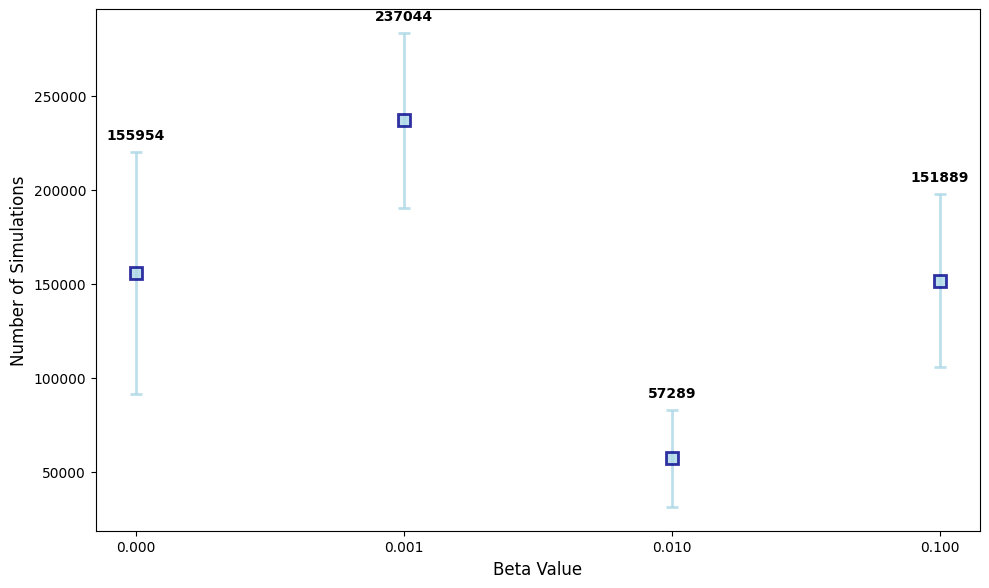

In [11]:
# Plot num_of_sim for pairwise metric
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate std for num_of_sim from original data
pairwise_original = data[data['metric'] == 'pairwise']
num_sim_stats = pairwise_original.groupby('beta')['num_of_sim'].agg(['mean', 'std']).reset_index()

# Get beta values, means, and standard deviations
beta_values = num_sim_stats['beta'].values + 1e-4
num_sims_mean = num_sim_stats['mean'].values
num_sims_std = num_sim_stats['std'].values


# Set up x positions
x_pos = np.arange(len(beta_values))
offset = 0.15  # Offset for separating beta and tau points

# Create line plot with error bars
ax.errorbar(x_pos, num_sims_mean, yerr=num_sims_std,
            fmt='s', markersize=8, capsize=4, 
            alpha=0.8, label='Mean Tau', 
            color='lightblue', markeredgecolor='darkblue', 
            markeredgewidth=2, linewidth=2)

# # Customize the plot
ax.set_xlabel('Beta Value', fontsize=12)
ax.set_ylabel('Number of Simulations', fontsize=12)
#ax.grid(True, alpha=0.3)
#ax.set_xscale('log')  # Log scale for beta values since they span orders of magnitude
ax.set_xticks(x_pos)
ax.set_xticklabels([f'{beta:.3f}' for beta in beta_values])

# Add value labels on points
for i, (beta, num_sim, std_val) in enumerate(zip(beta_values, num_sims_mean, num_sims_std)):
    ax.text(x_pos[i], num_sim + std_val + 5000,
            f'{num_sim:.0f}', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.show()

plt.savefig('pairwise_num_sims.pdf', dpi=300, bbox_inches='tight')

In [5]:
spatial_abc = SpatialSIR3D()

INFO:latent_abc_pmc:Initializing ViaABC class
INFO:latent_abc_pmc:Initialization complete
INFO:latent_abc_pmc:LatentABCSMC class initialized with the following parameters:
INFO:latent_abc_pmc:num_parameters: 2
INFO:latent_abc_pmc:Mu: [0.2 0.2]
INFO:latent_abc_pmc:Sigma: [4.5 4.5]
INFO:latent_abc_pmc:t0: 0
INFO:latent_abc_pmc:tmax: 16
INFO:latent_abc_pmc:time_space: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
INFO:latent_abc_pmc:pooling_method: no_cls
INFO:latent_abc_pmc:metric: pairwise_cosine


In [6]:
obs_data = np.load("/home/jp4474/latent-abc-smc/data/SPATIAL/data.npy")

In [7]:
generations = np.load("/home/jp4474/latent-abc-smc/spatialSIR3D_d128_ed64_6_8_4_8_vae_mask_0.15_beta_0.1/spatial_sir_inference_pairwise_cosine.npz", allow_pickle=True)['generations']

In [8]:
last_generation = generations[-1]
particles = last_generation['particles']

In [9]:
particles.shape

(1000, 2)

In [63]:
np.average(particles, axis=0, weights=weights)

array([1.01990342, 1.05916116])

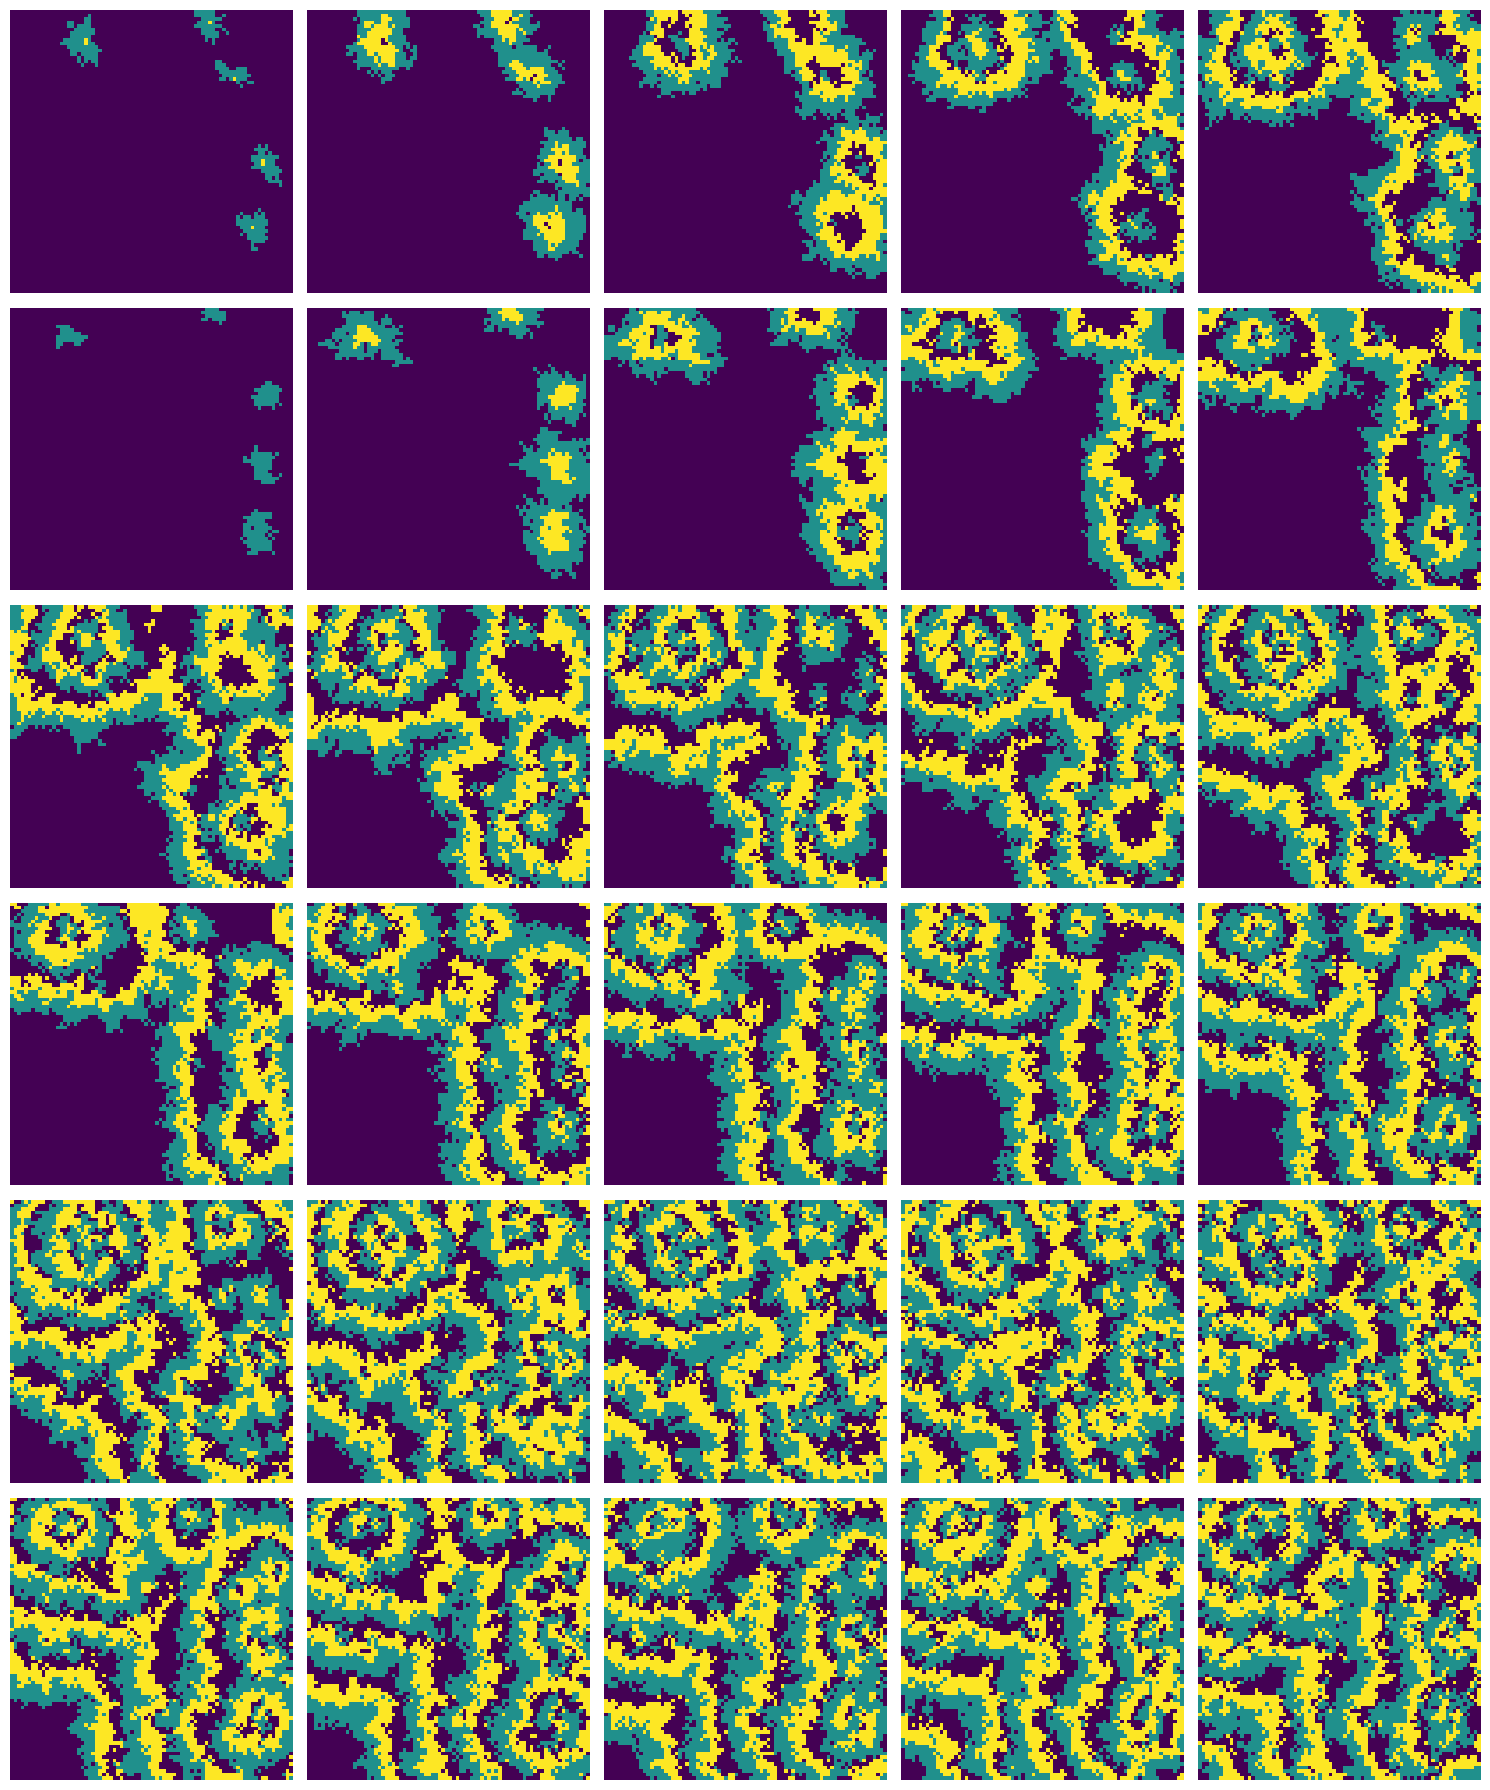

In [114]:
inferred_data = spatial_abc.simulate(np.average(particles, axis=0, weights=weights))[0]
# Enhanced comparison plot with 6x5 grid (30 slices total: 15 obs + 15 inf)
fig, ax = plt.subplots(6, 5, figsize=(15, 18))

# Convert inferred_data back to class labels for comparison
inferred_labels = np.argmax(inferred_data, axis=0)  # Convert from one-hot to class labels
obs_labels = obs_data #np.argmax(obs_data, axis=1)  # Convert from one-hot to class labels

# Organize by rows: 
# Row 0: obs 0-4, Row 1: inf 0-4, Row 2: obs 5-9, Row 3: inf 5-9, Row 4: obs 10-14, Row 5: inf 10-14
for row in range(6):
    for col in range(5):
        # Calculate which time block we're in (0-4, 5-9, or 10-14)
        time_block = row // 2  # 0, 1, or 2
        time_idx = time_block * 5 + col  # time index within the 15 time points
        
        if time_idx < 15:  # Make sure we don't exceed our data
            if row % 2 == 0:  # Even rows (0, 2, 4) - Observed data
                im = ax[row, col].imshow(obs_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
            else:  # Odd rows (1, 3, 5) - Inferred data
                im = ax[row, col].imshow(inferred_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
        
        ax[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.0)  # Make room for row labels and add horizontal spacing
# plt.show()
plt.savefig('observed_vs_inferred_6x5.pdf', dpi=300, bbox_inches='tight')

In [41]:
def mean_intersection_over_union(a, b):
    intersection = np.logical_and(a, b)
    union = np.logical_or(a, b)
    return np.sum(intersection) / np.sum(union)

def dice_index(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def multiclass_dice_index(y_true, y_pred):
    dice_scores = []
    for i in range(3):
        # find index where y_true == i
        argwhere_x = np.where(y_true == i, 1, 0)
        filtered_x = y_true[argwhere_x == 1]  # This gets original values
        filtered_y = y_pred[argwhere_x == 1]  # This gets original values
        score = dice_index(filtered_x, filtered_y)  # Dice expects binary inputs
        dice_scores.append(score)

        print(f"Class {i} Dice Index: {score:.4f}")
    return np.mean(dice_scores)


In [42]:
multiclass_dice_index(obs_data[0], inferred_data[0])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 80

In [57]:
inferred_labels.shape[0]

15

In [60]:
np.arange(0, 15, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

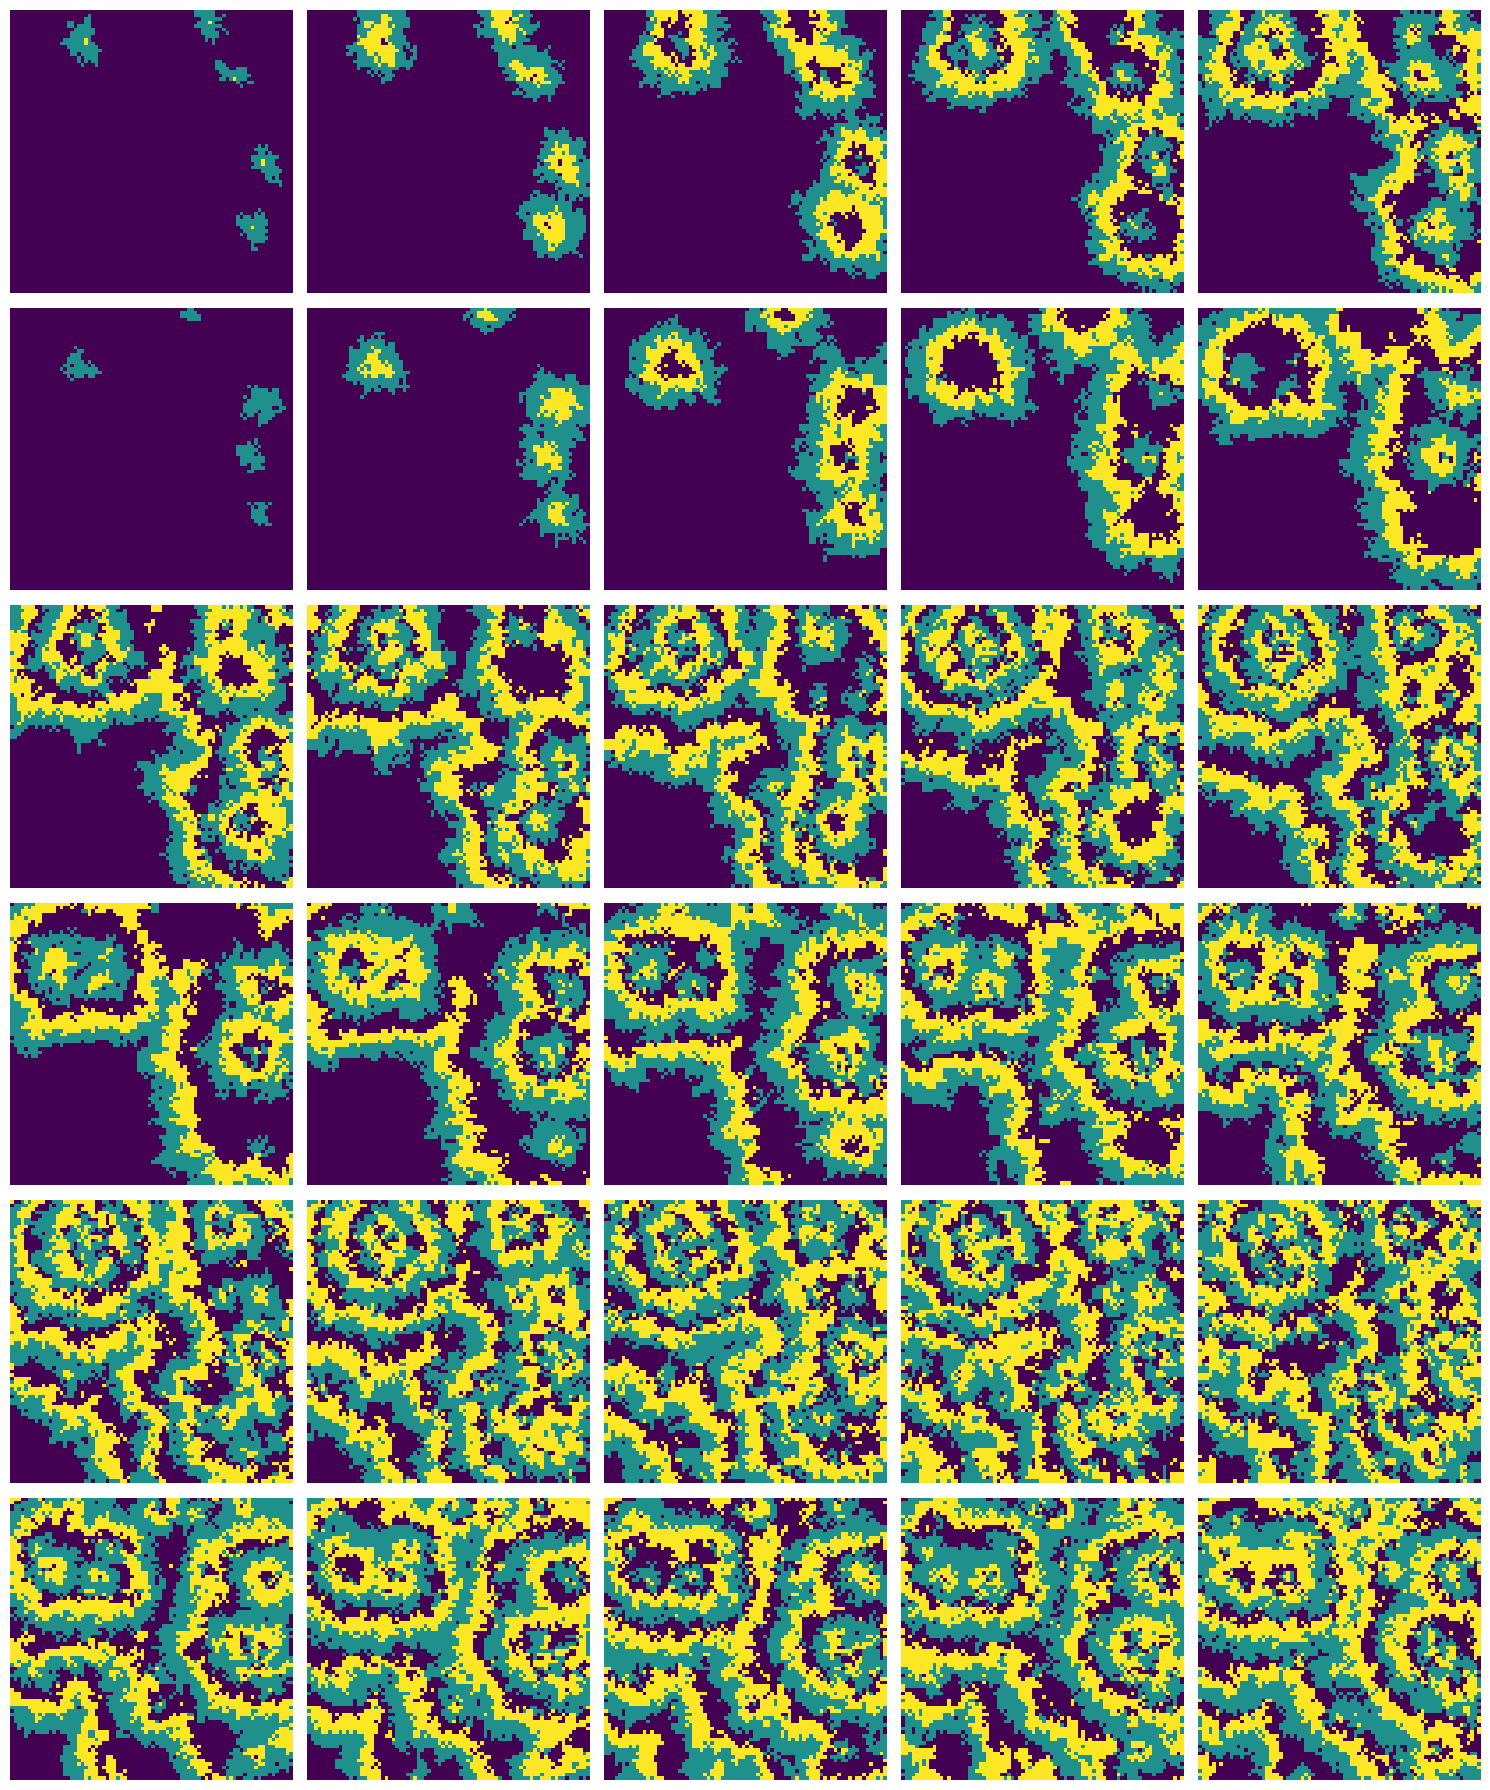

In [24]:
# Enhanced comparison plot with 6x5 grid (30 slices total: 15 obs + 15 inf)
fig, ax = plt.subplots(6, 5, figsize=(15, 18))

# Convert inferred_data back to class labels for comparison
inferred_labels = np.argmax(inferred_data, axis=0)  # Convert from one-hot to class labels
obs_labels = obs_data #np.argmax(obs_data, axis=1)  # Convert from one-hot to class labels

# Organize by rows: 
# Row 0: obs 0-4, Row 1: inf 0-4, Row 2: obs 5-9, Row 3: inf 5-9, Row 4: obs 10-14, Row 5: inf 10-14
for row in range(6):
    for col in range(5):
        # Calculate which time block we're in (0-4, 5-9, or 10-14)
        time_block = row // 2  # 0, 1, or 2
        time_idx = time_block * 5 + col  # time index within the 15 time points
        
        if time_idx < 15:  # Make sure we don't exceed our data
            if row % 2 == 0:  # Even rows (0, 2, 4) - Observed data
                im = ax[row, col].imshow(obs_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
            else:  # Odd rows (1, 3, 5) - Inferred data
                im = ax[row, col].imshow(inferred_labels[time_idx], cmap='viridis', vmin=0, vmax=2)
        
        ax[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.0)  # Make room for row labels and add horizontal spacing
# plt.show()
plt.savefig('observed_vs_inferred_6x5.pdf', dpi=300, bbox_inches='tight')

In [115]:
aggregated_results = np.load("/home/jp4474/latent-abc-smc/aggregated_results.npz", allow_pickle=True)['inferred_data']

In [71]:
aggregated_results.shape

(1000, 3, 100)

In [116]:
obs_data = np.load("/home/jp4474/latent-abc-smc/data/SPATIAL/data.npy")

In [6]:
obs_data.shape

(15, 80, 80)

In [118]:
def labels2map(y):
    """
    Convert 28 x 28 class labels into 3 x 28 x 28 binary masks.
    Assumes:
        - label_map is a torch.Tensor of shape (28, 28), where each pixel is 0, 1, or 2
    Returns:
        - imgs: torch.Tensor of shape (3, 28, 28), where each channel is a binary mask for class 0, 1, or 2
    """

    susceptible = (y == 0)
    infected = (y == 1)
    resistant = (y == 2)

    y_onehot = np.stack([susceptible, infected, resistant], axis=1)  # Shape: (3, H, W)

    return y_onehot

In [119]:
obs_data = labels2map(obs_data)

In [60]:
obs_data.shape

(15, 3, 80, 80)

In [33]:
(obs_data.sum(axis=(2,3))/(80*80)).shape

(15, 3)

In [79]:
obs_data.shape

(15, 80, 80)

obs_ts shape: (15, 3)


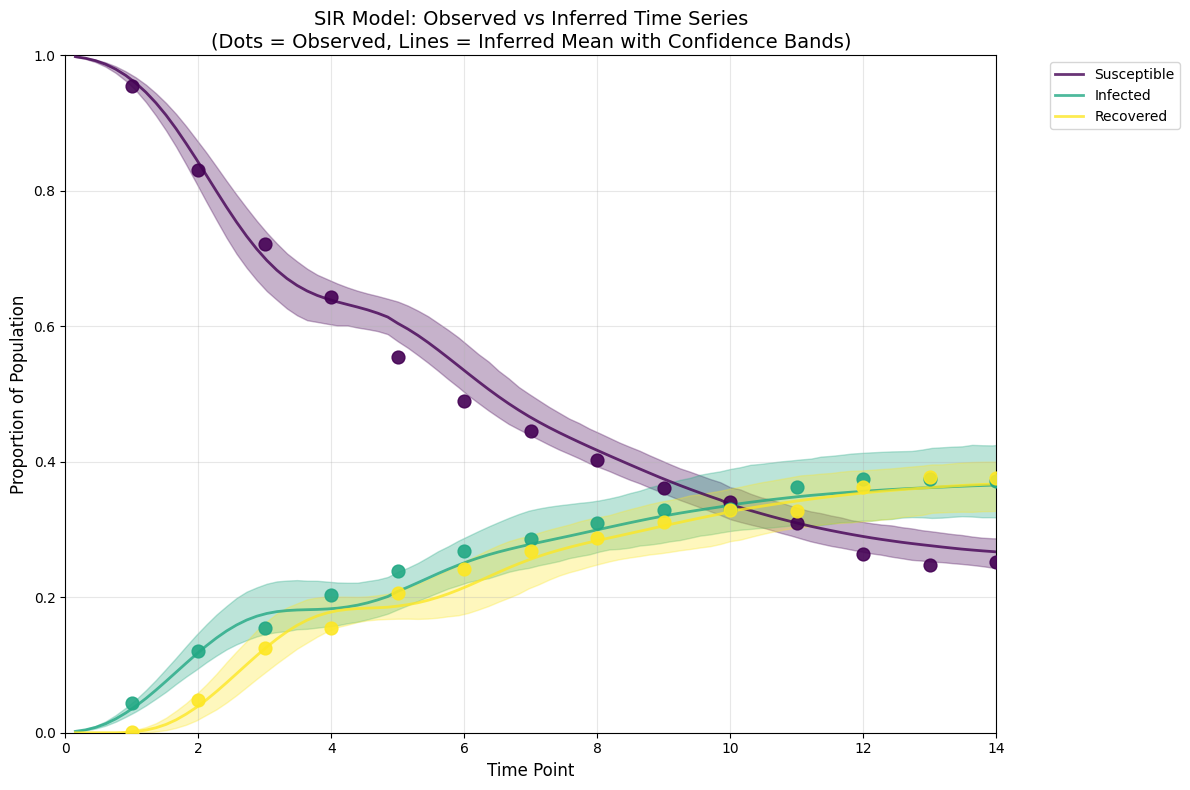

In [131]:
# Calculate observed data time series
# obs_data should have shape (15, 3, 80, 80) after labels2map
# Sum over spatial dimensions (last two axes) and normalize
obs_ts = (obs_data.sum(axis=(-2,-1))/(80*80))  # Shape: (15, 3)
print(f"obs_ts shape: {obs_ts.shape}")
ts = aggregated_results # shape: (1000, 3, 100)

# Create plot with both observed and inferred data
fig, ax = plt.subplots(figsize=(12, 8))

# Time points for observed data (exclude timestamp at 0)
obs_time_points = np.arange(1, 16, 1)
# Time points for inferred data
inferred_time_points = np.linspace(0, 15, 100)[1:]

# Colors for each compartment
# Viridis
colors = ['#440154', '#22A884', '#fde725']  # Viridis colors
labels = ['Susceptible', 'Infected', 'Recovered']

# Plot both observed and inferred data for each compartment
for compartment in range(3):
    # Plot observed data as scatter points
    ax.scatter(obs_time_points, obs_ts[:, compartment], 
            color=colors[compartment], marker='o', 
            alpha=0.9, s=85, zorder=5)
    
    # Get inferred data for this compartment across all simulations
    compartment_data = ts[:, compartment, 1:]  # Shape: (1000, 100)
    
    # Calculate mean and percentiles
    mean_values = np.mean(compartment_data, axis=0)
    p5 = np.percentile(compartment_data, 2.5, axis=0)
    p95 = np.percentile(compartment_data, 97.5, axis=0)
    
    # Plot mean line (combined legend entry)
    ax.plot(inferred_time_points, mean_values, color=colors[compartment], 
            linewidth=2, label=f'{labels[compartment]}',
            linestyle='-', alpha=0.8, zorder=4)
    
    # Plot 95% confidence interval
    ax.fill_between(inferred_time_points, p5, p95, 
                    color=colors[compartment], alpha=0.3, zorder=1)

# Customize the plot
ax.set_xlabel('Time Point', fontsize=12)
ax.set_ylabel('Proportion of Population', fontsize=12)
ax.set_title('SIR Model: Observed vs Inferred Time Series\n(Dots = Observed, Lines = Inferred Mean with Confidence Bands)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set reasonable limits
ax.set_xlim(0, 14)
ax.set_ylim(0, 1)

plt.tight_layout()
#plt.savefig('observed_vs_inferred_timeseries.pdf', dpi=300, bbox_inches='tight')
plt.show()